# Imports and definitions

In [15]:
import pandas as pd
from glob import glob
import urllib.parse
from tqdm import tqdm

In [16]:
root ='/scratch/tsoares/wikidumps/simplewiki-NS0-20230801/processed_data/'

# Load data

In [17]:
link_files = glob(root + 'links*')
link_files.sort()
link_files

['/scratch/tsoares/wikidumps/simplewiki-NS0-20230801/processed_data/links_0.parquet']

In [18]:
dfs = []
for file in link_files:
    print(f'Loading {file}')
    dfs.append(pd.read_parquet(file))
df_links = pd.concat(dfs)
df_links = df_links.reset_index(drop=True)
df_links

Loading /scratch/tsoares/wikidumps/simplewiki-NS0-20230801/processed_data/links_0.parquet


,target_title,target_section,source_title,target_ID,target_QID,source_ID,source_QID,anchor,source_section,link_start_index,link_end_index,sentence,sentence_start_index,sentence_end_index,source_page_length,link_section_depth
0,Month,Lead,April,3641,Q5151,1,Q118,month,Lead,4613,4682,) is the fourth month of the year in the Julia...,4597,5126,99844,0.0.0
1,Year,Lead,April,944,Q577,1,Q118,year,Lead,4690,4756,) is the fourth month of the year in the Julia...,4597,5126,99844,0.0.0
2,Julian_calendar,Lead,April,12158,Q11184,1,Q118,Julian,Lead,4764,4854,) is the fourth month of the year in the Julia...,4597,5126,99844,0.0.0
3,Gregorian_calendar,Lead,April,12159,Q12138,1,Q118,Gregorian calendars,Lead,4859,4968,) is the fourth month of the year in the Julia...,4597,5126,99844,0.0.0
4,March,Lead,April,468,Q110,1,Q118,March,Lead,4988,5057,) is the fourth month of the year in the Julia...,4597,5126,99844,0.0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722119,Ed_Bruce,Lead,Ever%2C_Never_Lovin%27_You,812433,Q346085,1034469,Q5416801,Ed Bruce,Lead,10429,10507,"\n""Ever, Never Lovin' You"" is a 1982 song by E...",10203,10838,26630,0.0.0
2722120,Placebo_%28band%29,Lead,Pure_Morning,113267,Q484839,1034472,Q2577326,Placebo,Lead,12215,12304,"Music video""Pure Morning"" at YouTube\n\n""Pure ...",11298,12305,45056,0.0.0
2722121,Indian,Lead,Ankit_Pachauri,264544,Q226324,1034521,None,Indian,Lead,6845,6937,"-- Image caption -->""},""birth_date"":{""wt"":""""},...",5623,7177,14281,0.0.0
2722122,Journalist,Lead,Ankit_Pachauri,41747,Q1930187,1034521,None,journalist,Lead,6938,7022,"-- Image caption -->""},""birth_date"":{""wt"":""""},...",5623,7177,14281,0.0.0


In [19]:
page_files = glob(root + 'pages*')
page_files.sort()
page_files

['/scratch/tsoares/wikidumps/simplewiki-NS0-20230801/processed_data/pages.parquet']

In [20]:
dfs = []
for file in page_files:
    print(f'Loading {file}')
    dfs.append(pd.read_parquet(file))
df_pages = pd.concat(dfs)
df_pages = df_pages.reset_index(drop=True)

Loading /scratch/tsoares/wikidumps/simplewiki-NS0-20230801/processed_data/pages.parquet


# Get statistics of exact matches in anchors

In [21]:
def levenshtein_distance(string_1, string_2):
    """
    Calculates the Levenshtein distance between two strings.
    """
    distances = [[0 for x in range(len(string_2) + 1)] for x in range(len(string_1) + 1)]
    for i in range(1, len(string_1) + 1):
        distances[i][0] = i
    for j in range(1, len(string_2) + 1):
        distances[0][j] = j
    for i in range(1, len(string_1) + 1):
        for j in range(1, len(string_2) + 1):
            if string_1[i - 1] == string_2[j - 1]:
                distances[i][j] = distances[i - 1][j - 1]
            else:
                distances[i][j] = 1 + min(distances[i][j - 1], distances[i - 1][j], distances[i - 1][j - 1])
    return distances[len(string_1)][len(string_2)]

In [22]:
counter = [0 for _ in range(11)]
for i in tqdm(range(len(df_links))):
    title = urllib.parse.unquote(df_links['target_title'][i]).replace('_', ' ').lower()
    anchor = df_links['anchor'][i].lower()
    if title == anchor:
        counter[0] += 1
    else:
        distance = levenshtein_distance(title, anchor)
        counter[min(distance, 10)] += 1

100%|██████████| 2722124/2722124 [01:56<00:00, 23356.37it/s]


In [23]:
for elem in counter:
    print(elem/sum(counter))

0.6584516355610546
0.06121800476392699
0.017670392678658282
0.025784644637790195
0.0118253246362032
0.013089043702638086
0.01596180041761507
0.01816669630038896
0.018304456373038114
0.028400249217155428
0.13112775171153115


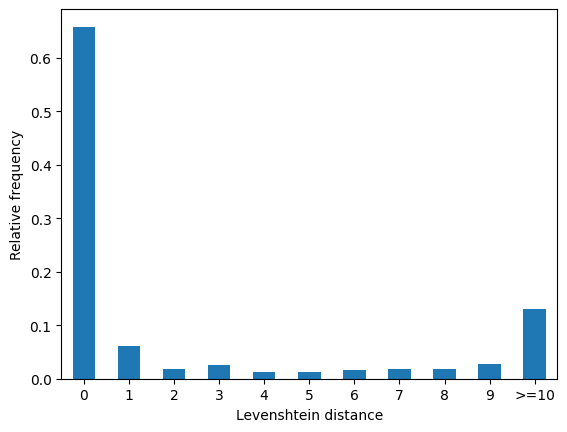

In [24]:
# create histogram from counter
# use pandas to create a dataframe
import matplotlib.pyplot as plt
df = pd.DataFrame([elem / len(df_links) for elem in counter], columns=['relative_frequency'])
df['levenshtein_distance'] = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>=10']
# plot relative frequency histogram
# the last bin should have legend '>=10'
df.plot.bar(x='levenshtein_distance', y='relative_frequency', rot=0, legend=False)
plt.xlabel('Levenshtein distance')
plt.ylabel('Relative frequency')
plt.show()


In [25]:
print(df)

    relative_frequency levenshtein_distance
0             0.658452                    0
1             0.061218                    1
2             0.017670                    2
3             0.025785                    3
4             0.011825                    4
5             0.013089                    5
6             0.015962                    6
7             0.018167                    7
8             0.018304                    8
9             0.028400                    9
10            0.131128                 >=10


# Analysis of issues with links

In [26]:
# How many links are missing source QIDs?
len(df_links[df_links['source_QID'].isna()])

411

In [27]:
# How many links are missing target QIDs?
len(df_links[df_links['target_QID'].isna()])

525

In [28]:
missing_leads = set([])
for i in range(len(df_pages)):
    if df_pages['lead_paragraph'][i] == '':
        missing_leads.add(df_pages['title'][i])

missing_target_lead = 0
missing_source_lead = 0
for i in tqdm(range(len(df_links))):
    if df_links['source_title'][i] in missing_leads:
        missing_source_lead += 1
    if df_links['target_title'][i] in missing_leads:
        missing_target_lead += 1

100%|██████████| 2722124/2722124 [00:28<00:00, 96030.73it/s]


In [30]:
print(missing_source_lead)
print(missing_target_lead)
print(len(missing_leads))

15839
44156
1417


In [31]:
# how many links do we have if we remove all the offending links?
df_links = df_links[~df_links['source_title'].isin(missing_leads)]
df_links = df_links[~df_links['target_title'].isin(missing_leads)]
df_links = df_links[~df_links['source_QID'].isna()]
df_links = df_links[~df_links['target_QID'].isna()]
len(df_links)

2662046

# Analysis of token size distribution

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []
for i in tqdm(range(len(df_pages))):
    title = df_pages['lead_paragraph'][i]
    tokenized_title = tokenizer(title)
    token_lens.append(len(tokenized_title['input_ids']))

In [ ]:
token_series = pd.Series(token_lens)
token_series.describe()